In [2]:
import pandas as pd
from plotnine import *

In [3]:
or_events = pd.read_parquet('./outage_report_2019-20')

In [4]:
filtered_or_events = or_events[(or_events['vendor'] != '') & (or_events['vendor'] != 'overview')].reset_index(drop=True)
filtered_or_events = filtered_or_events.drop_duplicates(subset=['vendor', 'event_time', 'status_code'])
# Combine events with the same event_time, but different status_code with max
filtered_or_events = filtered_or_events.groupby(['vendor', 'event_time'])['status_code'].max().reset_index()

In [5]:
filtered_or_events['evtime'] = pd.to_datetime(filtered_or_events['event_time'], unit='s')

In [6]:
def proper_vendor_names(series):
    return series.str.capitalize().replace(['Apple-servers', 'Facebook-messenger', 'Youtube'], ['Apple', 'FB Msgr', 'YouTube'])

filtered_or_events['vendor_proper'] = proper_vendor_names(filtered_or_events['vendor'])

In [7]:
vendor_list = list(filtered_or_events.groupby('vendor_proper')['status_code'].sum().reset_index().rename(columns={'status_code':'count'}).sort_values('count')['vendor_proper'])
vendor_list

['Apple',
 'Github',
 'Skype',
 'FB Msgr',
 'Gmail',
 'Whatsapp',
 'Snapchat',
 'Netflix',
 'Facebook',
 'Twitter',
 'YouTube',
 'Instagram']

In [8]:
filtered_or_events['year'] = pd.Categorical(filtered_or_events['evtime'].dt.year, ordered=True)
filtered_or_events['month'] = pd.Categorical(filtered_or_events['evtime'].dt.month, ordered=True)
filtered_or_events['vendor_cat'] = pd.Categorical(filtered_or_events['vendor_proper'], ordered=True, categories=vendor_list)

In [16]:
reports_per_month = filtered_or_events.groupby(['year', 'month', 'vendor_cat'])['status_code'].sum().reset_index().rename(columns={'status_code':'count'})
subset_reports_per_month = reports_per_month[(reports_per_month['month'] > 3) & (reports_per_month['month'] < 9)]
subset_reports_per_month['count'].sum()

367336.0

In [10]:
report_count_df_list = []

for vendor in subset_reports_per_month['vendor_cat'].unique():
    partial_df = subset_reports_per_month[subset_reports_per_month['vendor_cat'] == vendor].reset_index(drop=True)
    max_reports = partial_df['count'].max()
    partial_df['prop'] = partial_df['count'] / max_reports
    report_count_df_list.append(partial_df)
    
reports_per_month_with_prop = pd.concat(report_count_df_list)

/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:727: PlotnineWarning: Saving 14 x 3 in image.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: plots/covid_comparison.pdf
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.
/Users/sacheendra/miniconda3/envs/thesis/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_bar : Removed 1 rows containing missing values.


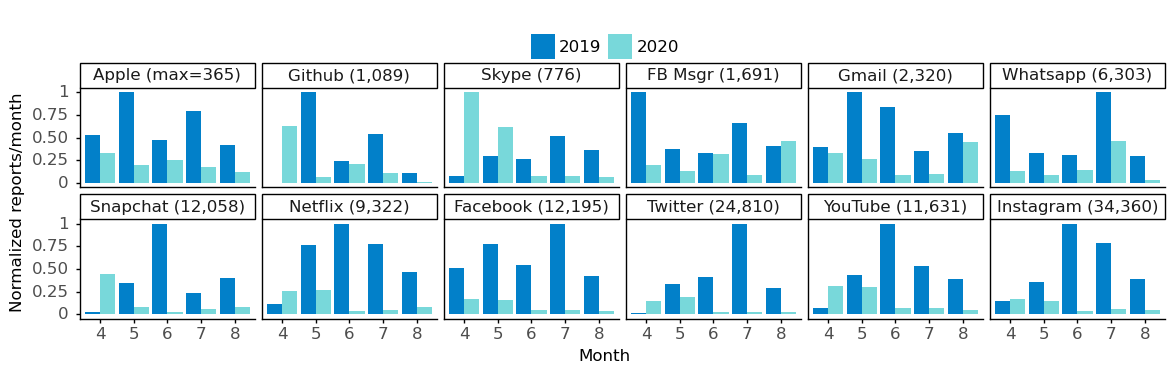

<ggplot: (323781768)>

In [13]:
vendor_maxes = reports_per_month_with_prop.groupby('vendor_cat')['count'].max()

def label_func(vendor):
    if vendor == 'Apple':
        return vendor + ' (max={:,})'.format(int(vendor_maxes.loc[vendor]))
    else:
        return vendor + ' ({:,})'.format(int(vendor_maxes.loc[vendor]))

plt = ggplot(reports_per_month_with_prop) +\
    theme_classic(base_size=12, base_family='sans-serif') +\
    theme(figure_size=(14, 3),
          axis_text_y=element_text(margin={'r': 5}),
          panel_grid_minor_x=element_line(size=0.7, color="gainsboro"),
          panel_grid_major_x=element_blank(),
          text=element_text(size=12),
          legend_box_spacing=0.01,
          legend_box_margin=0,
          legend_margin=0,
          legend_key=element_blank(),
          legend_entry_spacing=5,
          legend_background=element_rect(fill=(0,0,0,0), color=(0,0,0,0)),
          legend_position='top',) +\
    facet_wrap(facets='vendor_cat', nrow=2, labeller=label_func) +\
    geom_bar(aes(x='month', y='prop', fill='year'), stat='identity', position='dodge') +\
    scale_fill_manual(['#0280c9', '#78d8da']) +\
    guides(fill=guide_legend(title='')) +\
    xlab('Month') +\
    ylab('Normalized reports/month')

plt.save('plots/covid_comparison.pdf', limitsize=False)
plt